# Performance Evaluation 



### Evaluation Methodology
Model execution produces a 1-km grid SWE estimates across the Sierra Nevada Mountains and we can use the Standardized Snow Water Equivalent Evaluation tool (SSWEET) to perform a comphrehensive model evaluation against NASA ASO and snow course surveys.
<img align = 'right' src="./Images/RMSE_R2.JPG" alt = 'image' width = '200'/>

SSWEET uses standard model evaluation metrics to guage model performance (i.e., Percent Bias (PBias, Coefficient of Determination (R2), Kling-Gupta Efficiency (KGE), and root mean squared error (RMSE)) and includes several methods to investitage the impacts of temporal-spatial characteristics influence model skill, ultimately to help refine model skill.
A deep read through [The Abuse of Popular Performance Metrics in Hydrological Modeling](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020WR029001) will provide more insight into model evaluation metrics and how to interpret their results related to model performance.

PBias is a metric communicating the average tendency of the simulated values to be larger or smaller than their observed ones. 
The optimal value of PBias is 0.0, with low-magnitude values indicating accurate model simulation.

The coefficient of determination (R<sup>2</sup>) is a unitless measurement of the proportion of explained variance of the target variable by the model.
A maximum R<sup>2</sup> score of 1.0 indicates the predictor variables explain 100 percent of the variation in the target. 
A greater R<sup>2</sup> and lower RMSE represent better model predictive performance. 

KGE is simply the Euclidean distance computed using the coordinates of bias, standard deviation, and correlation. 
Similar to the coefficient of determination, values closer to 1 indicate greater model skill and due to the calculation of KGE, it will be lower than the bias, standard deviation, and correlation.

RMSE is the quadratic mean of the differences between the observation and predictions, or residuals. 
RMSE aggregate the magnitudes of the residuals for all data points into a single measure of average model predictive power, with RMSE communicating the accuracy of the model.
Note, RMSE is scale dependent.

## Preliminary Model Evaluation
Preliminary model evaluation is on the 25% held out testing data, where the known previous SWE values from NASA ASO flights support the previous SWE feature during model inference.
The following evaulation uses SSWEET to analyze model performance and statistically benchmark improvements compared to the current NSM.

### Model Training/Testing influences and Bias on Model Performance.

The model training/testing partitioning methodology has a strong influence on model performance and the goal of model evaluation.
The objective of the modeling effort was to examine the spatial extrapolation capacity of the model from selected monitoring stations to the overall region, best suited to a 75/25% training/testing split, respectively.

While it is critical to address the strong serial correlation in SWE accumulation and melt throughout the season, the high correlation between weeks has the potential to inflate model skill when using a 75/25% training/testing split due to the previous SWE feature being known.
An assessment of the operational capacity of the model is different than assessing the ability to extrapolate regional SWE from in-situ monitoring stations and is the reason WY 2019 was held out of the training data as it will form the final model validation.


In [1]:
import os
import pandas as pd
from scripts import SSWEET, Hindcast_Initialization
import warnings

warnings.filterwarnings("ignore")

#Set working directories
cwd = os.getcwd()
os.chdir("../..")
datapath = os.getcwd() 

### Load your model data

As long as model development followed the prescribed template, the SSWEET.load_Predictions() function will correctly load and process model predictions and observations.

In [2]:
#Get datetime and corresponding background information to evaluate hindcast
#Need to load predictions2022-09-24.h5, 2019_predictions.h5 (if straight to here and did not make predictions)  

new_year = '2019'
threshold = '20.0'
Region_list = ['N_Sierras','S_Sierras_High', 'S_Sierras_Low']

datelist = Hindcast_Initialization.Hindcast_Initialization(cwd, datapath, new_year, threshold, Region_list)
EvalDF = Hindcast_Initialization.HindCast_DataProcess(datelist,Region_list,cwd, datapath)

Creating files for a historical simulation within  'N_Sierras', 'S_Sierras_High', 'S_Sierras_Low'  regions for water year  2019
New simulation start files complete


## Parity Plot

A parity plot is a scatterplot that compares a set of model estimates against benchmark data, i.e., the observations.
Each point has coordinates (x, y), where x is a benchmark value and y is the corresponding value from the model.
A parity plot is often the first visualization to investigate the skill of a model.

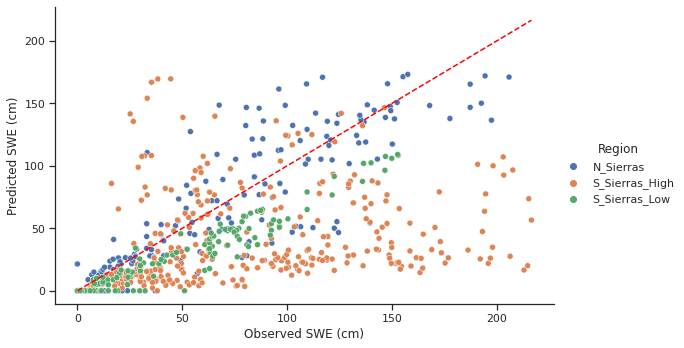

,Region,R2,RMSE,KGE,PBias,R2_fSCA,RMSE_fSCA,KGE_fSCA,PBias_fSCA
0,N_Sierras,0.73,27.82,0.86,2.81,0.73,27.82,0.86,2.81
1,S_Sierras_High,-0.76,71.07,0.03,49.61,-0.76,71.07,0.03,49.61
2,S_Sierras_Low,0.65,24.61,0.5,39.98,0.65,24.61,0.5,39.98
3,Sierras_All,-0.03,53.69,0.39,35.62,-0.03,53.69,0.39,35.62


In [3]:
SSWEET.parityplot(EvalDF)


## More in-depth model evaluation.
We want to evaluate the model over the course of seasonal snow accumulation and melt, at differnt elevation bands, and spatially.


Using SSWEET, the Model_Vs() function supports an in-depth evaluation of multiple model skill influencing components to conduct a robust and comprehensive evaluation of a model.
The Model_Vs() function takes the following inputs: Model_Vs(RegionTest,variable,Model Output, datapath), where
* RegionTest is the prediction dataframe saved from the training notebook.
* variable is the variable of interest. Currently supported variables include Water Year Week (WYWeek), Elevation (elevation_m), Previous SWE Estimate (prev_SWE), Latitude (Lat), and Northness (northness), and Error due to Previous SWE Estimate (prev_SWE_error).
* Model Output refers to one of three model outputs or processed model outputs including: Predictions (Prediction), Error (Error) which is the physical difference between each prediction and observation, and Percent Error (Percent_Error) which is Error divided by the Observation and multiplied by 100%.

The following examples demonstrate the utilty of the SSWEET and the Model_Vs() function.


### Error over time

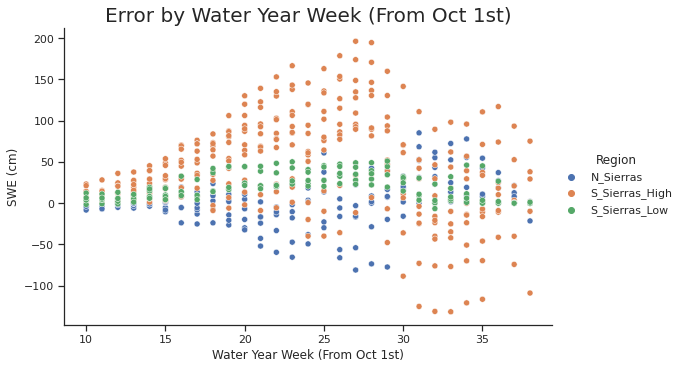

In [4]:
SSWEET.Model_Vs(EvalDF,'WYWeek', 'Error', datapath)

### Error compared to elevation

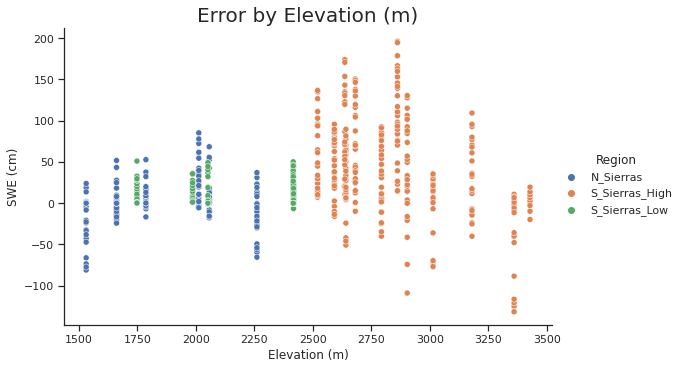

In [5]:
SSWEET.Model_Vs(EvalDF,'elevation_m', 'Error', datapath)

### Percent Error compared to elevation
*note, error greater than |100%| is adjusted to |100%| 

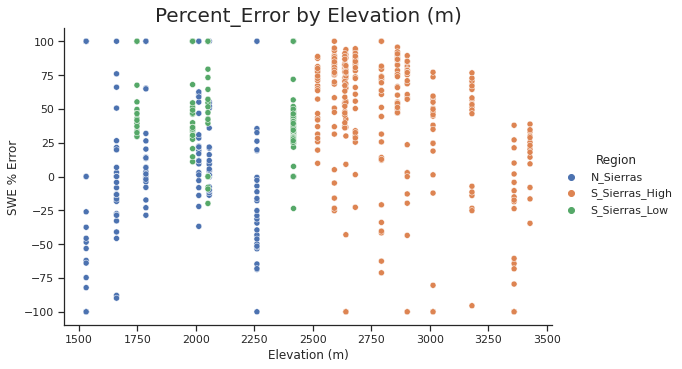

In [6]:
SSWEET.Model_Vs(EvalDF,'elevation_m', 'Percent_Error', datapath)

### Model error  compared to northness


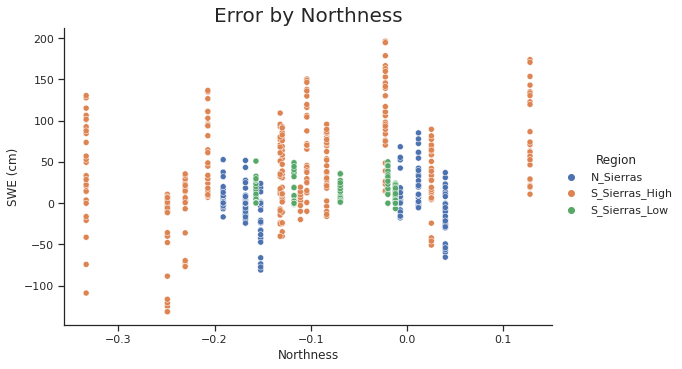

In [7]:
SSWEET.Model_Vs(EvalDF,'northness', 'Error', datapath)

## Interactive Spatial Plotting
While fitures support evaluation, spatially examining model performance has several benefits adn the Map_Plot_Eval function() supports a spatial method to evaluate model skill.
The Map_Plot_Eval(datapath, RegionTest, yaxis, error_metric) function supports three different evaluation metrics: 'KGE', 'cm', or '%'.
The physical error (cm) illustrates how close the predictions are to the observed, the mean percentage error (%) illustrates the perentagewise prediction accuracy, and KGE (KGE) illustrates the mean, variance and correlation on model performance, however, it is only useful for sites with multiple predictions. 

### Spatially evaluating the Model via KGE
Selecting the prediction where there was a previous SWE value demonstrates significanly increased KGE. Note, the blue icons are the SNOTEL sites used to inform predictions and are more visible now. 
When running interactively, clicking on the SNOTEL icon shows the SNOTEL site information and allwos for an investigation of errors stemming from the proximity of the prediction locations to in situ observations.



In [8]:
#Folium plot
SSWEET.Map_Plot_Eval(datapath, EvalDF,'SWE (cm)', 'KGE')

Processing Dataframe into timeseries format: predictions, observations, error.


100%|██████████| 628/628 [00:00<00:00, 649.85it/s]


Plotting monitoring station locations


### Spatially evaluating the Model via error in percentage from the observed

We can now see that the model can spatially extrapolate and that there is a significant need for improved temporal resolution data. 
For this case, KGE does not provide a useful method to evaluate the model.
Alternatively, the Map_Plot_Eval() function supports percent error (%) and physical error (cm).

In [9]:
#Folium plot
SSWEET.Map_Plot_Eval(datapath, EvalDF,'SWE (cm)', '%')

Processing Dataframe into timeseries format: predictions, observations, error.


100%|██████████| 628/628 [00:00<00:00, 651.14it/s]


Plotting monitoring station locations


### Spatially evaluating the Model via error in cm




In [10]:
#Folium plot
SSWEET.Map_Plot_Eval(datapath, EvalDF,'SWE (cm)', 'cm')

Processing Dataframe into timeseries format: predictions, observations, error.


100%|██████████| 628/628 [00:00<00:00, 633.14it/s]


Plotting monitoring station locations


### Other examples of using SSWEET to investigate model performance

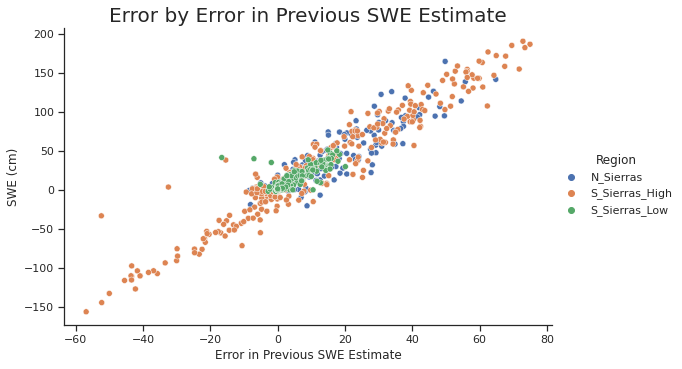

In [11]:
SSWEET.Model_Vs(EvalDF,'prev_SWE_error', 'Error', datapath)

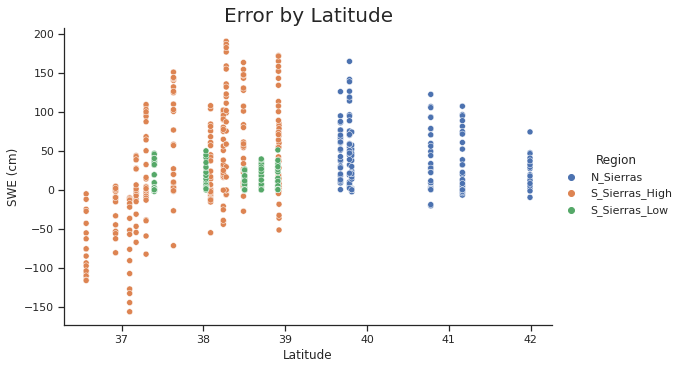

In [12]:
SSWEET.Model_Vs(EvalDF,'Lat', 'Error', datapath)

## Exploring the Prediction results

While model error is a critical metric to gauge model skil, simple checks on model predictions can support the use of a model or high areas for improvement.
For example, it montane regions, SWE generally increases in elevation up to the apline (or above treeline). 
Capturing this trend is important and a critical element of model evaluation.
Once above treeline (~2,900 m in the Sierra Nevada mountains), SWE distribution is significantly affected by overall and microclimate wind speed and direction, leaving some high altitude regions completly bare and others with large amounts of SWE. 
Note, many of these aspects are scale dependent (e.g., a 50 m, 250 m, 1 km, and 25 km model will vary significantly due to varying geopatial characteristics and key hydrological processes).


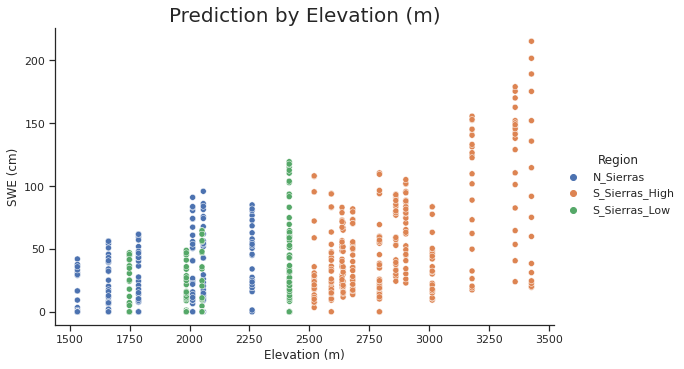

In [13]:
SSWEET.Model_Vs(EvalDF,'elevation_m', 'Prediction', datapath)

Effective modeling of elevation gradients leads to a realistic modeled SWE across heterogeneous terrain. 
For example, the  higher elevation bands display greater modeled SWE values compared to lower elevations, and the highest elevation bands display less SWE reflecting exposed terrain subject to wind transport and snow redistribution.
This is indicative that the model is capable of generalizing topographical and geographical characteristics to effectivley translate elevation gradients on SWE.


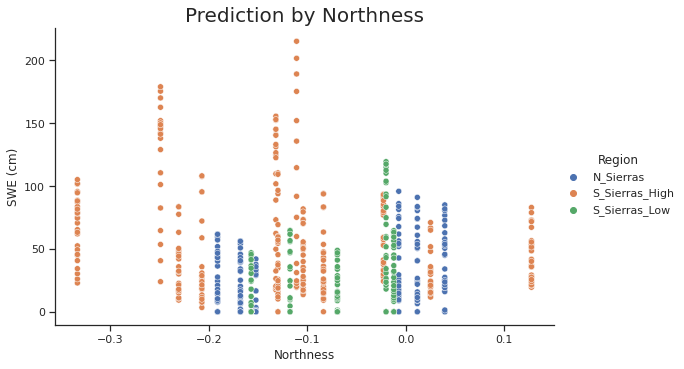

In [14]:
SSWEET.Model_Vs(EvalDF,'northness', 'Prediction', datapath)

While the model uses northness as a feature to represent the average slope and aspect of the 1-km grid, overlaying the predictions on complex topography indicates a need for high resolution prediction.
Examination of the 1-km resolution indicates it is too coarse to capture rapid topographical changes common to montane environments, but does indicate an increas in northness lead to an increase in SWE.
Investigating the distribution of observation/predictions indicates there is a need to a larger, more comprehensive training dataset to capture key influences on SWE distribution in montane environments. 

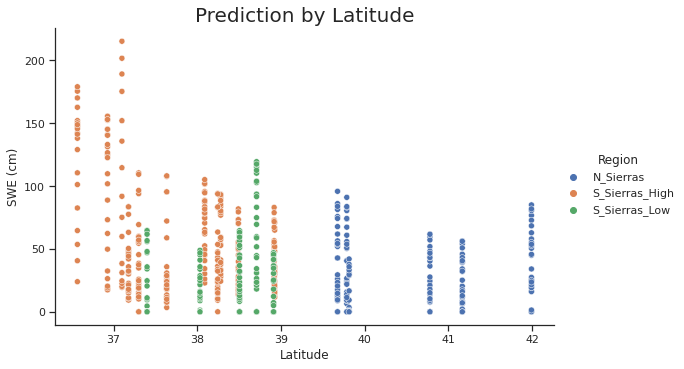

In [15]:
SSWEET.Model_Vs(EvalDF,'Lat', 'Prediction', datapath)